In [1]:
using PyPlot
using JLD

include("../src/histogram_merging.jl")

INFO: Recompiling stale cache file /Users/ludwig/.julia/lib/v0.4/Conda.ji for module Conda.
INFO: Recompiling stale cache file /Users/ludwig/.julia/lib/v0.4/PyPlot.ji for module PyPlot.


fit_histogram_merging (generic function with 1 method)

In [2]:
function exactdp(ys::Array{Float64, 1}, k::Int)
    return fit_histogram_dp(ys, k)
end

function merging_k(ys::Array{Float64, 1}, k::Int)
    return fit_histogram_merging(ys, sigma, k, floor(Int, k / 2.0), initial_merging_size=1)
end

function merging_2k(ys::Array{Float64, 1}, k::Int)
    return fit_histogram_merging(ys, sigma, 2 * k, k, initial_merging_size=1)
end

function merging_4k(ys::Array{Float64, 1}, k::Int)
    return fit_histogram_merging(ys, sigma, 4 * k, 2 * k, initial_merging_size=1)
end

algos = Dict([("exactdp", exactdp), ("merging_k", merging_k), ("merging_2k", merging_2k), ("merging_4k", merging_4k)])

Dict{ASCIIString,Function} with 4 entries:
  "exactdp"    => exactdp
  "merging_2k" => merging_2k
  "merging_4k" => merging_4k
  "merging_k"  => merging_k

In [3]:
num_data_sets = 10
num_trials = 10
sigma = 1.0
n_vals = round(Int, logspace(2.0, 4.0, 7))
k = 10
mses = Dict{ASCIIString, Array{Float64, 2}}()
times = Dict{ASCIIString, Array{Float64, 2}}()

for algo_name in keys(algos)
    mses[algo_name] = Array(Float64, length(n_vals), num_trials * num_data_sets)
    times[algo_name] = Array(Float64, length(n_vals), num_trials * num_data_sets)
end

# Warm-up for pre-compilation
n_warmup = 1000
bin_values = rand(1:10, k);
y, ystar = generate_equal_size_histogram_data(bin_values, n_warmup, sigma)
@printf("Warm-up with n = %d\n", n_warmup)
for (algo_name, algo_fun) in algos
    yhat_partition = algo_fun(y, k)
end

for (nii, n) in enumerate(n_vals)
    @printf("n = %d  ", n)
    
    tic()
    for iidata = 1:num_data_sets
        bin_values = rand(1:10, k);
        @printf(".")
        
        for ii = 1:num_trials
            #@printf("  trial %d\n", ii)
            y, ystar = generate_equal_size_histogram_data(bin_values, n, sigma)

            for (algo_name, algo_fun) in algos
                #@printf("    algorithm %s\n", algo_name)
                start_time = time_ns()
                yhat_partition = algo_fun(y, k)
                end_time = time_ns()
                yhat = partition_to_vector(yhat_partition)
                mses[algo_name][nii, (iidata - 1) * num_trials + ii] = mse(yhat, ystar)
                times[algo_name][nii, (iidata - 1) * num_trials + ii] = 1e-9 * (end_time - start_time)
            end
        end
    end
    elapsed = toq()
    @printf("  %f seconds\n", elapsed)
end

mses_mean = Dict{AbstractString, Array{Float64, 1}}()
mses_std = Dict{AbstractString, Array{Float64, 1}}()
times_mean = Dict{AbstractString, Array{Float64, 1}}()
times_std = Dict{AbstractString, Array{Float64, 1}}()
for algo_name in keys(mses)
    mses_mean[algo_name] = vec(mean(mses[algo_name], 2))
    mses_std[algo_name] = vec(std(mses[algo_name], 2))
    times_mean[algo_name] = vec(mean(times[algo_name], 2))
    times_std[algo_name] = vec(std(times[algo_name], 2))
end

Warm-up with n = 1000
n = 100  ..........  0.105312 seconds
n = 215  ..........  0.253779 seconds
n = 464  ..........  1.047164 seconds
n = 1000  ..........  4.757507 seconds
n = 2154  ..........  21.520506 seconds
n = 4642  ..........  98.735108 seconds
n = 10000  ..........  437.372096 seconds


In [4]:
algo_colors = Dict([("exactdp", "blue"), ("merging_2k", "green"), ("merging_4k", "red"), ("merging_k", "olive")])

Dict{ASCIIString,ASCIIString} with 4 entries:
  "exactdp"    => "blue"
  "merging_2k" => "green"
  "merging_4k" => "red"
  "merging_k"  => "olive"

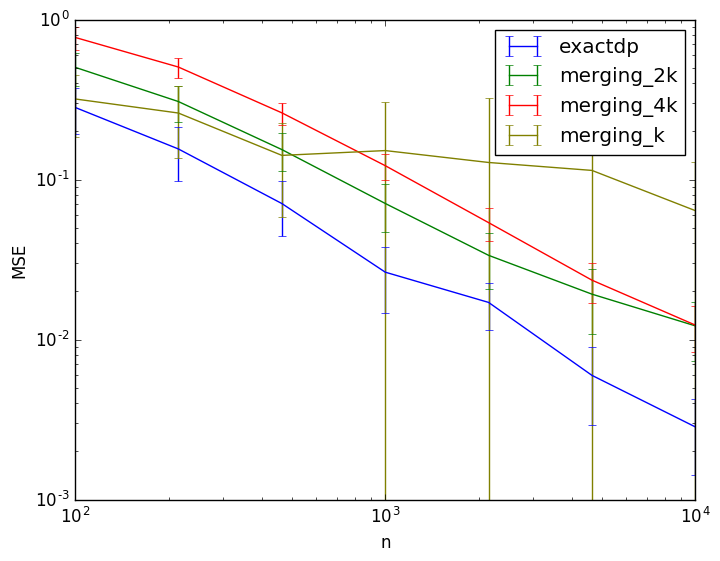

PyObject <matplotlib.text.Text object at 0x319f5ab10>

In [5]:
for (algo_name, algo_mses) in mses_mean
    errorbar(n_vals, algo_mses, yerr=mses_std[algo_name], label=algo_name, color=algo_colors[algo_name])
end
#plot(n_vals, 200.0 ./ n_vals, label="C/n")
#plot(n_vals, 5.0 ./ sqrt(n_vals), label="C/sqrt(n)", color="olive")
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("MSE")

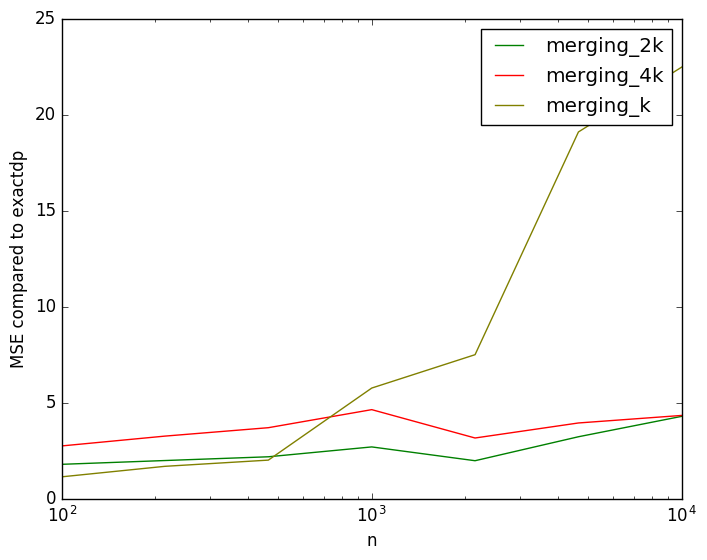

PyObject <matplotlib.text.Text object at 0x31aa033d0>

In [6]:
exactdp_mses = mses_mean["exactdp"]
for (algo_name, algo_mses) in mses_mean
    if algo_name != "exactdp"
        plot(n_vals, algo_mses ./ exactdp_mses, label=algo_name, color=algo_colors[algo_name])
    end
end
legend()
xscale("log")
xlabel("n")
ylabel("MSE compared to exactdp")

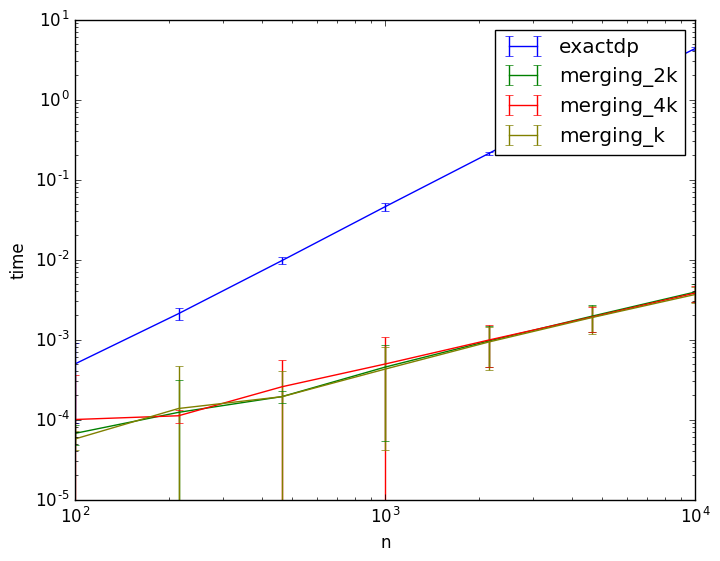

PyObject <matplotlib.text.Text object at 0x31ae32610>

In [7]:
for (algo_name, algo_times) in times_mean
    errorbar(n_vals, algo_times, yerr=times_std[algo_name], label=algo_name, color=algo_colors[algo_name])
end
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("time")

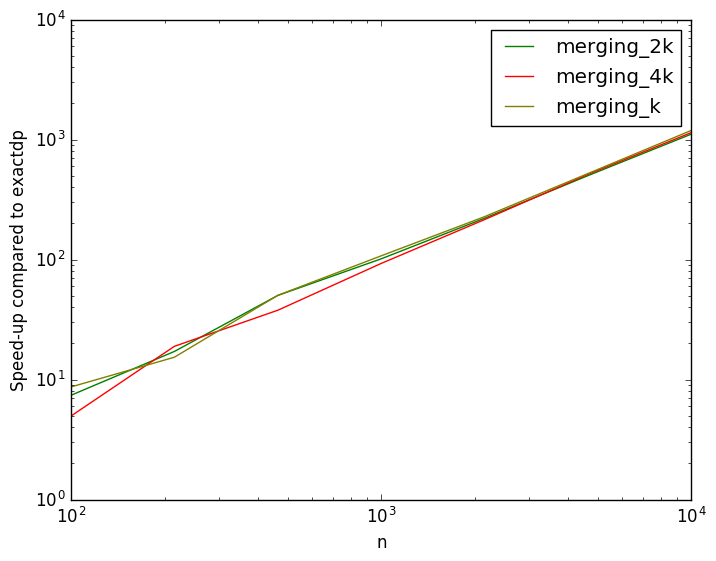

PyObject <matplotlib.text.Text object at 0x31b559a10>

In [8]:
exactdp_times = times_mean["exactdp"]
for (algo_name, algo_times) in times_mean
    if algo_name != "exactdp"
        plot(n_vals, exactdp_times ./ algo_times, label=algo_name, color=algo_colors[algo_name])
    end
end
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("Speed-up compared to exactdp")

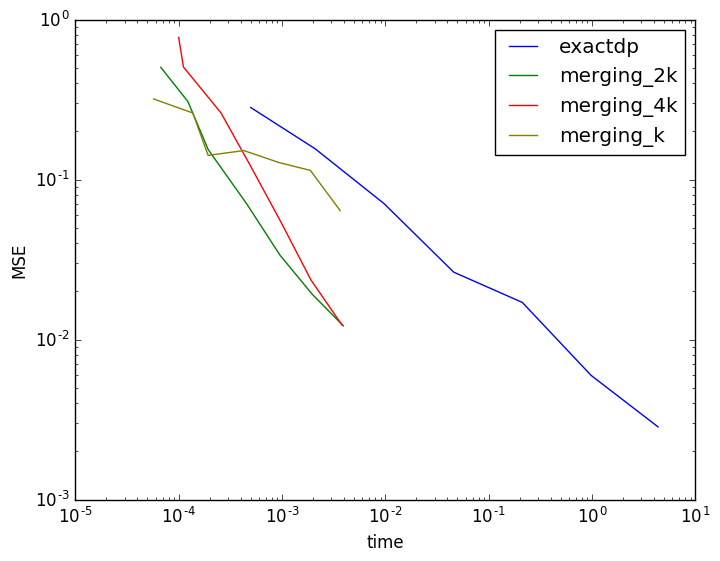

PyObject <matplotlib.text.Text object at 0x31baea690>

In [9]:
for (algo_name, algo_times) in times_mean
    plot(algo_times, mses_mean[algo_name], label=algo_name, color=algo_colors[algo_name])
end
legend()
yscale("log")
xscale("log")
xlabel("time")
ylabel("MSE")

In [13]:
extra_algos = Dict([("merging_k", merging_k), ("merging_2k", merging_2k), ("merging_4k", merging_4k)])
extra_n_vals = round(Int, logspace(4.0, 6.0, 7))
extra_mses = Dict{ASCIIString, Array{Float64, 2}}()
extra_times = Dict{ASCIIString, Array{Float64, 2}}()

for algo_name in keys(extra_algos)
    extra_mses[algo_name] = Array(Float64, length(extra_n_vals), num_trials * num_data_sets)
    extra_times[algo_name] = Array(Float64, length(extra_n_vals), num_trials * num_data_sets)
end

# Warm-up for pre-compilation
n_warmup = 1000
bin_values = rand(1:10, k);
y, ystar = generate_equal_size_histogram_data(bin_values, n_warmup, sigma)
@printf("Warm-up with n = %d\n", n_warmup)
for (algo_name, algo_fun) in extra_algos
    yhat_partition = algo_fun(y, k)
end

for (nii, n) in enumerate(extra_n_vals)
    @printf("n = %d  ", n)
    
    tic()
    for iidata = 1:num_data_sets
        bin_values = rand(1:10, k);
        @printf(".")
        
        for ii = 1:num_trials
            #@printf("  trial %d\n", ii)
            y, ystar = generate_equal_size_histogram_data(bin_values, n, sigma)

            for (algo_name, algo_fun) in extra_algos
                #@printf("    algorithm %s\n", algo_name)
                start_time = time_ns()
                yhat_partition = algo_fun(y, k)
                end_time = time_ns()
                yhat = partition_to_vector(yhat_partition)
                extra_mses[algo_name][nii, (iidata - 1) * num_trials + ii] = mse(yhat, ystar)
                extra_times[algo_name][nii, (iidata - 1) * num_trials + ii] = 1e-9 * (end_time - start_time)
            end
        end
    end
    elapsed = toq()
    @printf("  %f seconds\n", elapsed)
end

extra_mses_mean = Dict{AbstractString, Array{Float64, 1}}()
extra_mses_std = Dict{AbstractString, Array{Float64, 1}}()
extra_times_mean = Dict{AbstractString, Array{Float64, 1}}()
extra_times_std = Dict{AbstractString, Array{Float64, 1}}()
for algo_name in keys(extra_mses)
    extra_mses_mean[algo_name] = vec(mean(extra_mses[algo_name], 2))
    extra_mses_std[algo_name] = vec(std(extra_mses[algo_name], 2))
    extra_times_mean[algo_name] = vec(mean(extra_times[algo_name], 2))
    extra_times_std[algo_name] = vec(std(extra_times[algo_name], 2))
end

Warm-up with n = 1000
n = 10000  ..........  1.319317 seconds
n = 21544  ..........  2.920168 seconds
n = 46416  ..........  6.078963 seconds
n = 100000  ..........  15.734706 seconds
n = 215443  ..........  37.866558 seconds
n = 464159  ..........  93.528341 seconds
n = 1000000  ..........  196.356639 seconds


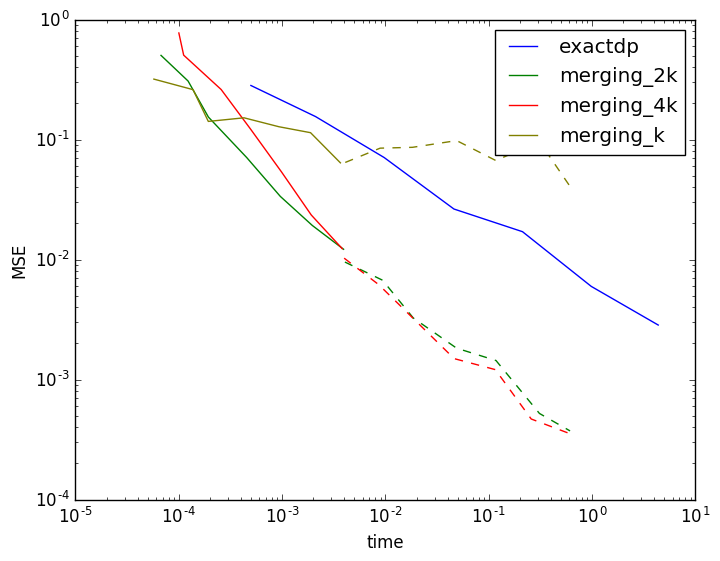

PyObject <matplotlib.text.Text object at 0x31dda4190>

In [14]:
for (algo_name, algo_times) in times_mean
    plot(algo_times, mses_mean[algo_name], label=algo_name, color=algo_colors[algo_name])
end
for (algo_name, algo_times) in extra_times_mean
    plot(algo_times, extra_mses_mean[algo_name], color=algo_colors[algo_name], linestyle="--")
end
legend()
yscale("log")
xscale("log")
xlabel("time")
ylabel("MSE")

In [9]:
mses_std

Dict{AbstractString,Array{Float64,1}} with 4 entries:
  "exactdp"    => [0.12335422562005727,0.08988066584984726,0.04346081940242209,…
  "merging_2k" => [0.147290987767189,0.1035263893802247,0.04822492140304131,0.0…
  "merging_4k" => [0.1444960789141127,0.0961772292219326,0.04924958048057618,0.…
  "merging_k"  => [0.1789028292274192,0.1515439992927351,0.09092572478359237,0.…

In [14]:
times["merging_2k"]

7x100 Array{Float64,2}:
 6.9306e-5    5.2826e-5    5.4409e-5    …  7.9696e-5    5.0154e-5  
 9.6458e-5    9.878e-5     0.00010168      0.000102159  0.000109644
 0.000193693  0.000214643  0.00205235      0.000188399  0.000205386
 0.000452794  0.000376234  0.000376045     0.000367917  0.000344326
 0.000780319  0.000751964  0.00072282      0.00102656   0.000844636
 0.00146779   0.00225696   0.00232453   …  0.00280549   0.00149523 
 0.00342455   0.00570933   0.00333552      0.00321926   0.00459405 

In [15]:
times_std["merging_2k"]

7-element Array{Float64,1}:
 2.48313e-5 
 0.000220548
 0.000323453
 0.000334593
 0.000462064
 0.000698449
 0.000903554

In [15]:
@save "experiments2_k10.jld"

In [24]:
include("../src/helpers.jl")

write_experiment_data_with_ratios (generic function with 1 method)

In [19]:
write_experiment_data("constant", "exactdp", n_vals, mses_mean, mses_std, times_mean, times_std)

In [25]:
for algo_name in keys(algos)
    write_experiment_data_with_ratios("experiments2_k10", algo_name, "exactdp", n_vals, mses_mean, mses_std, times_mean, times_std)
end

In [26]:
for algo_name in keys(extra_algos)
    write_experiment_data("experiments2_k10_extra", algo_name, extra_n_vals, extra_mses_mean, extra_mses_std, extra_times_mean, extra_times_std)
end